In [2]:
# Import stuff
import os
import scipy
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import theano

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

In [3]:
taste_dat = np.load('taste_data.npy')
print(taste_dat.shape)
# Trial x Nrn x Time

(30, 10, 7000)


In [4]:
# Convert spikes to counts by binning
time_lims = [2000,4000]
bin_width = 25
t_vec = np.arange(taste_dat.shape[-1])
binned_t_vec = np.mean(t_vec[time_lims[0]:time_lims[1]].reshape((-1,bin_width)),axis=-1)
this_dat_binned = np.sum(taste_dat[...,time_lims[0]:time_lims[1]].reshape(*taste_dat.shape[:-1],-1,bin_width),axis=-1)
this_dat_binned = np.vectorize(np.int)(this_dat_binned)

(30, 10, 80)


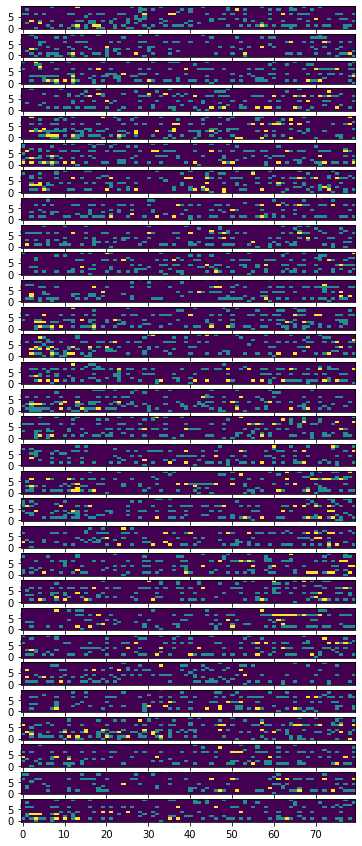

In [5]:
# Pick single trial
trial = np.arange(taste_dat.shape[0])
count_data = this_dat_binned[trial]
#count_data = np.sum(this_dat_binned,axis=0)
n_count_data = count_data.shape[-1]

fig, ax = plt.subplots(len(trial),1, figsize = (6,15))
for this_ax, this_dat in zip(ax.flatten(),count_data):
    this_ax.imshow((this_dat>0)*1 + (this_dat>1), interpolation = 'nearest', aspect = 'auto', origin = 'lower')
fig.savefig('binned_raster')

count_data = count_data>0
print(count_data.shape)
# Nrn X Time_bin

In [6]:
states = 3
split_list = np.array_split(count_data,states,axis=-1)
# Cut all to the same size
min_val = min([x.shape[-1] for x in split_list])
split_array = np.array([x[...,:min_val] for x in split_list])
mean_vals = np.mean(split_array,axis=(1,-1))
mean_vals += 0.01 # To avoid zero starting prob
print(mean_vals.shape) # Trials x nrns
print(mean_vals)

(3, 10)
[[0.09205128 0.39589744 0.16897436 0.29717949 0.23692308 0.03051282
  0.34974359 0.04846154 0.09589744 0.12025641]
 [0.05871795 0.30871795 0.15871795 0.09333333 0.27153846 0.01512821
  0.33435897 0.03564103 0.12282051 0.14846154]
 [0.08692308 0.40358974 0.14974359 0.07538462 0.29461538 0.01769231
  0.45487179 0.08820513 0.12923077 0.12153846]]


In [7]:
idx = np.arange(n_count_data) # Index
array_idx = np.broadcast_to(idx, count_data.shape)
idx_range = idx.max() - idx.min()
print(idx.min())
print(idx.max())
print(array_idx.shape)

0
79
(30, 10, 80)


(3, 10)


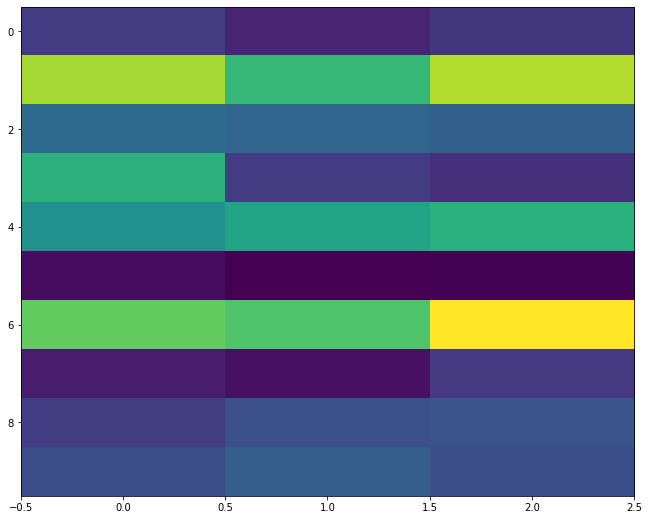

In [8]:

lambda_names = ['lambda_{}'.format(i+1) for i in range(states)]
with pm.Model() as model:
    
    
    # SAME LAMBDAS ACROSS ALL TRIALS
    # Finite, but somewhere on the lower end, Beta prior
    #a_lambda = pm.HalfNormal('a_lambda', 2.)
    #b_lambda = pm.HalfNormal('b_lambda', 5.)
    a_lambda = 2
    b_lambda = 5
    
    #lambda_latent = pm.math.stack(
    #                    [pm.Beta(lambda_names[i], a_lambda, b_lambda, testval = mean_vals[i], 
    #                               shape = (mean_vals.shape[1])) \
    #                     for i in range(states)]
    #)
    lambda_latent = pm.Beta('lambda', a_lambda, b_lambda, testval = mean_vals, 
                                   shape = (states,mean_vals.shape[1]))
    
print(lambda_latent.tag.test_value.shape)
plt.imshow(lambda_latent.tag.test_value.T,aspect='auto');

In [9]:
even_switches = np.linspace(0,idx.max(),states+1)
even_switches_normal = even_switches/np.max(even_switches)
print(even_switches)
print(even_switches_normal[1:(states)])

[ 0.         26.33333333 52.66666667 79.        ]
[0.33333333 0.66666667]


In [10]:
#tau_names = ['tau_{}'.format(i+1) for i in range(states-1)]
with model:
    
    
    # INDEPENDENT TAU FOR EVERY TRIAL
    a = pm.HalfNormal('a_tau', 3., shape = states - 1)
    b = pm.HalfNormal('b_tau', 3., shape = states - 1)
    
    a_broad = tt.tile(a,(count_data.shape[0],1))
    b_broad = tt.tile(b,(count_data.shape[0],1))
    
#print(a.tag.test_value.shape)
print(a_broad.tag.test_value.shape)
    
    # More specific hyperprior for each changepoint
    # E(x ~ Beta) = a/(a+b) = c
    # Constraint : a + b = 6 (pretty arbitrary), c <= 1 (property of distribution)
    #a = 6*c
    #b = 6-a
#     a_vec = even_switches_normal[1:(states)]*6
#     b_vec = 6 - a_vec
#     a_dist_vec = [pm.HalfNormal('a_tau_{}'.format(i), a_vec[i]) for i in range(len(a_vec))]
#     b_dist_vec = [pm.HalfNormal('b_tau_{}'.format(i), b_vec[i]) for i in range(len(b_vec))]
#     print(a_vec)
#     print(b_vec)

(30, 2)


In [11]:
with model:
    
    # Stack produces states x trials --> That gets transposed to trials x states and gets sorted along states (axis=-1)
    # Sort should work the same way as the Ordered transform --> see rv_sort_test.ipynb
    #tau_latent = pm.math.stack([
    #                   pm.Beta(tau_names[i], a_dist_vec[i], b_dist_vec[i], 
    #                           shape = count_data.shape[0], testval = even_switches_normal[1+i]) \
    #               for i in range(states-1)]).T.sort(axis=-1)
    
    #tau_latent = pm.Beta('tau_latent', a, b, 
    #                       shape = (states-1,count_data.shape[0])).T.sort(axis=-1)
    tau_latent = pm.Beta('tau_latent', a_broad, b_broad, 
                           shape = (count_data.shape[0], states-1),
                            testval = np.tile(even_switches_normal[1:(states)], (count_data.shape[0],1))).sort(axis=-1)
    print(tau_latent.tag.test_value.shape)
       
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
print(tau.tag.test_value.shape)


(30, 2)
(30, 2)


(30, 10, 80)
(30, 10, 80)


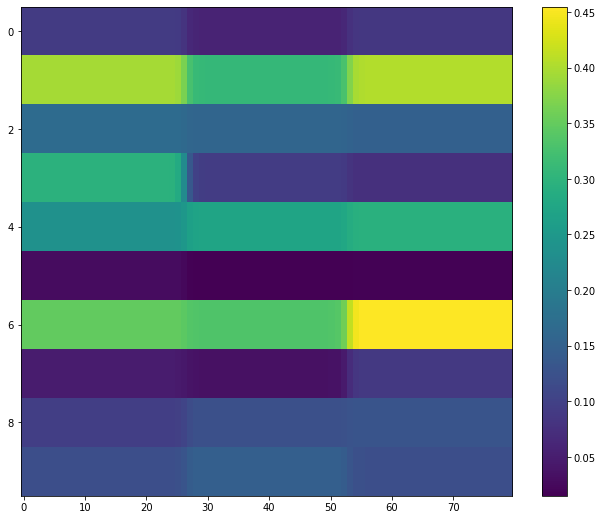

In [12]:
with model:
    
    # Assign lambdas to time_bin indices using sigmoids centered on switchpoints
    # Refer to https://www.desmos.com/calculator/yisbydv2cq
    
    weight_1_stack = tt.nnet.sigmoid(2 * (array_idx - tau[:,0][:,np.newaxis,np.newaxis]))
    weight_2_stack = tt.nnet.sigmoid(2 * (array_idx - tau[:,1][:,np.newaxis,np.newaxis]))
    #weight_3_stack = tt.nnet.sigmoid(2 * (array_idx - tau[:,2][:,np.newaxis,np.newaxis]))
    #weight_4_stack = tt.nnet.sigmoid(2 * (array_idx - tau[:,3][:,np.newaxis,np.newaxis]))
    
    lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[0][np.newaxis,:,np.newaxis]) + \
                np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[1][np.newaxis,:,np.newaxis]) + \
                np.multiply(weight_2_stack, lambda_latent[2][np.newaxis,:,np.newaxis])
                #np.multiply(weight_2_stack * (1 - weight_3_stack), lambda_latent[2][np.newaxis,:,np.newaxis]) + \
                #np.multiply(weight_3_stack * (1 - weight_4_stack), lambda_latent[3][np.newaxis,:,np.newaxis]) + \
                

print(weight_1_stack.tag.test_value.shape)
#print(weight_stack.tag.test_value.shape)
print(lambda_.tag.test_value.shape)
plt.imshow(lambda_.tag.test_value[0],aspect='auto');plt.colorbar();

In [13]:
# Using Bernoullo likelihood for count data
with model:
    observation = pm.Bernoulli("obs", lambda_, observed=count_data)

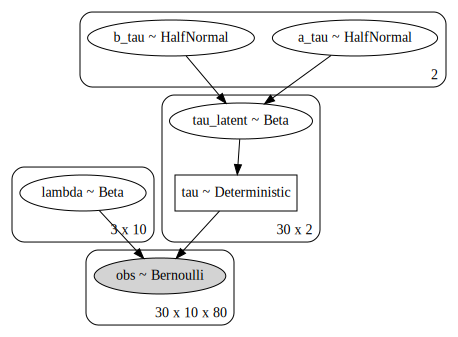

In [14]:
pm.model_to_graphviz(model)

In [15]:
with model:
    #inference = pm.ADVI('full-rank')
    #approx = pm.fit(n=30000, method=inference)
    #trace = approx.sample(draws=10000)
    step= pm.Metropolis()
    #step= pm.NUTS()
    trace = pm.sample(2000, tune=1000, 
                      step = step,
                      chains = 4, cores = 4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_latent]
>Metropolis: [b_tau]
>Metropolis: [a_tau]
>Metropolis: [lambda]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:24<00:00, 489.51draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [16]:
# plt.plot(-inference.hist, label='new ADVI', alpha=.3)
# plt.plot(approx.hist, label='old ADVI', alpha=.3)
# plt.legend()
# plt.ylabel('ELBO')
# plt.xlabel('iteration');

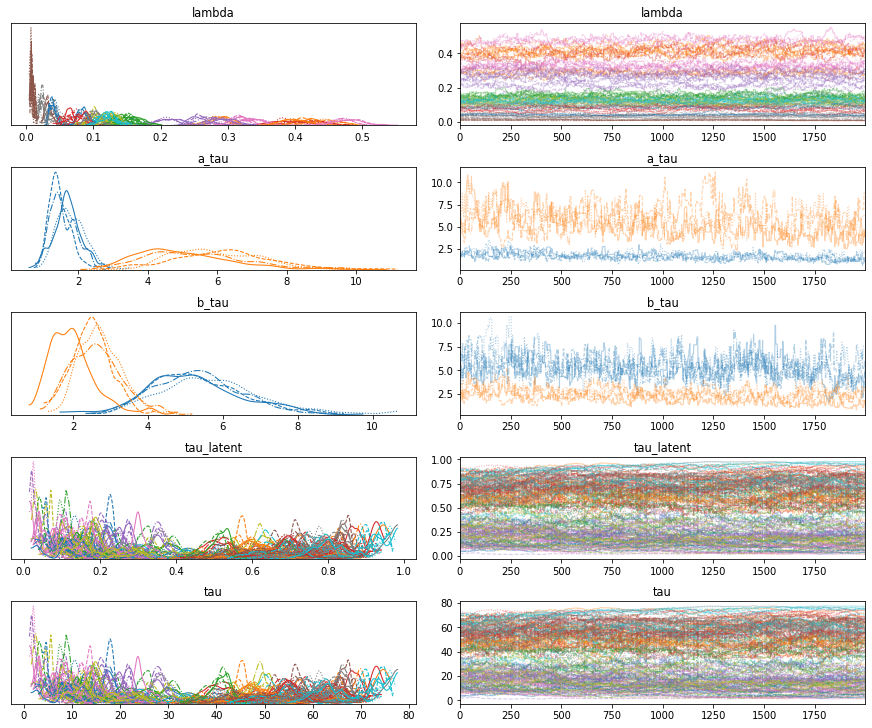

In [18]:
pm.traceplot(trace);

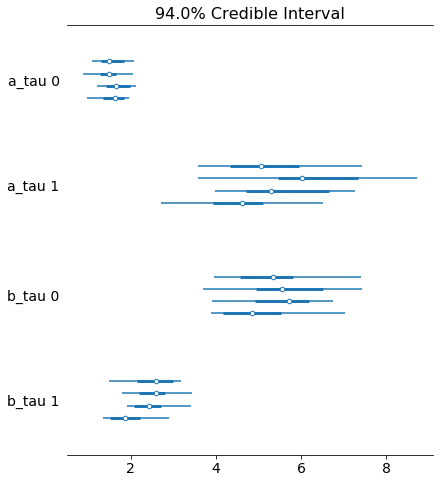

In [17]:
pm.forestplot(trace[::100], var_names = ['a_tau','b_tau']);

In [114]:
#pm.forestplot(trace[::100], combined=True, var_names = ['lambda_1','lambda_2','lambda_3','lambda_4']);

In [115]:
#pm.summary(trace[::100]).round(2)

In [116]:
# lambda_1_samples = trace['lambda_1']
# lambda_2_samples = trace['lambda_2']
# lambda_3_samples = trace['lambda_3']
# lambda_4_samples = trace['lambda_4']
# lambda_5_samples = trace['lambda_5']
# lambda_stack = np.stack([lambda_1_samples,
#                             lambda_2_samples,
#                             lambda_3_samples,
#                             lambda_4_samples,
#                             lambda_5_samples])
lambda_stack = trace['lambda'].swapaxes(0,1)
#tau_1_samples = trace['tau_1']
#tau_2_samples = trace['tau_2']
#tau_samples = np.stack([tau_1_samples, tau_2_samples])
tau_samples = trace['tau']
print(tau_samples.shape)
print(lambda_stack.shape)

(40000, 30, 2)
(3, 40000, 10)


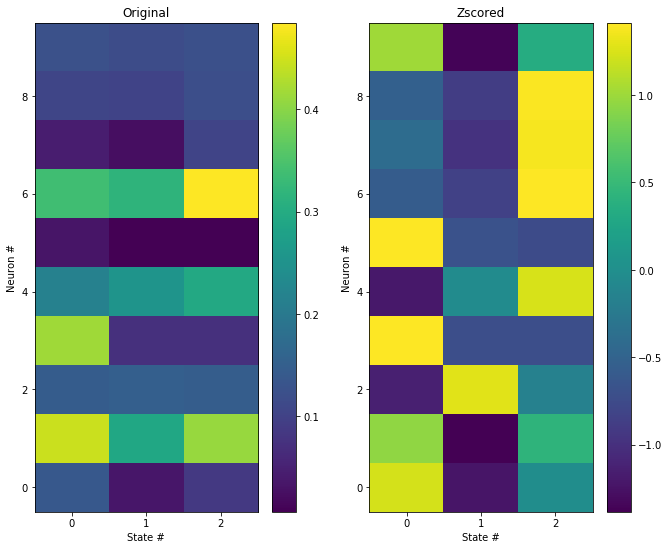

In [117]:
mean_lambda = np.mean(lambda_stack,axis=1)
fig = plt.figure()
ax = fig.add_subplot(121)
plt.imshow(mean_lambda.T, aspect='auto', origin='lower');plt.colorbar();
plt.xticks(np.arange(mean_lambda.shape[0]));
plt.xlabel('State #');
plt.ylabel('Neuron #');
plt.title('Original')
ax = fig.add_subplot(122)
plt.imshow(stats.zscore(mean_lambda.T,axis=-1), aspect='auto', origin='lower');plt.colorbar();
plt.xticks(np.arange(mean_lambda.shape[0]));
plt.xlabel('State #');
plt.ylabel('Neuron #');
plt.title('Zscored')
fig.savefig('predicted_firing_per_state')

In [118]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)
ppc['obs'].shape

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:04<00:00, 405.54it/s]


(2000, 30, 10, 80)

In [119]:
mean_ppc = np.mean(ppc['obs'],axis=0)
std_ppc = np.std(ppc['obs'],axis=0)
print(mean_ppc.shape)

(30, 10, 80)


(30, 2)


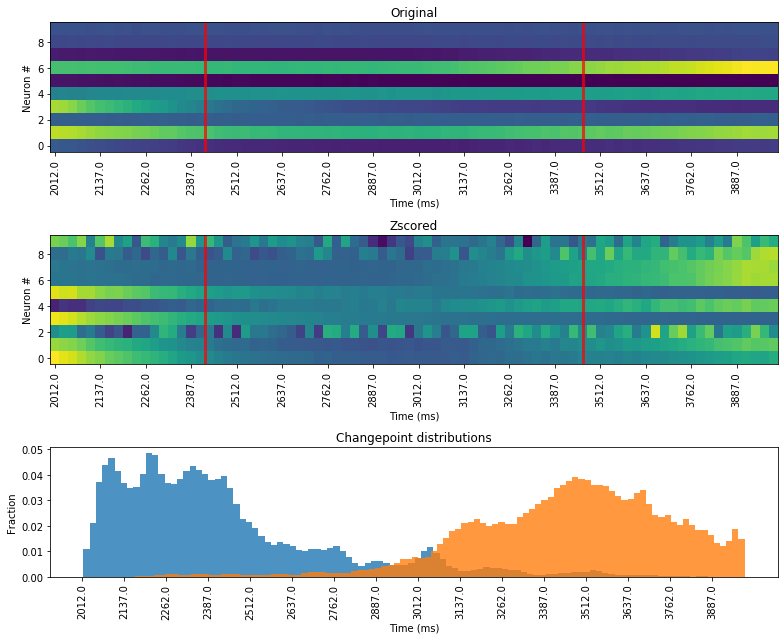

In [120]:
mean_tau = np.mean(tau_samples,axis=0)
print(mean_tau.shape)
tick_interval = 5
fig = plt.figure()
ax = fig.add_subplot(311)
ax.imshow(np.mean(mean_ppc,axis=0), aspect='auto', origin='lower')
plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
plt.vlines(np.mean(mean_tau,axis=0),-0.5,count_data.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7);
plt.xlabel('Time (ms)');
plt.ylabel('Neuron #');
plt.title('Original')
ax = fig.add_subplot(312)
ax.imshow(stats.zscore(np.mean(mean_ppc,axis=0),axis=-1), aspect='auto', origin='lower')
plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
plt.vlines(np.mean(mean_tau,axis=0),-0.5,count_data.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7);
plt.xlabel('Time (ms)');
plt.ylabel('Neuron #');
plt.title('Zscored')
ax = fig.add_subplot(313)
long_tau_samples = tau_samples.reshape((-1,tau_samples.shape[-1]))
for switch in range(long_tau_samples.shape[-1]):
    ax.hist(long_tau_samples[...,switch],bins = 100, density = True,alpha = 0.8)
plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
#plt.vlines(np.mean(mean_tau,axis=0),-0.5,count_data.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7);
plt.xlabel('Time (ms)');
plt.ylabel('Fraction');
plt.title('Changepoint distributions')
plt.tight_layout()
fig.savefig('average_predicted_timeseries')

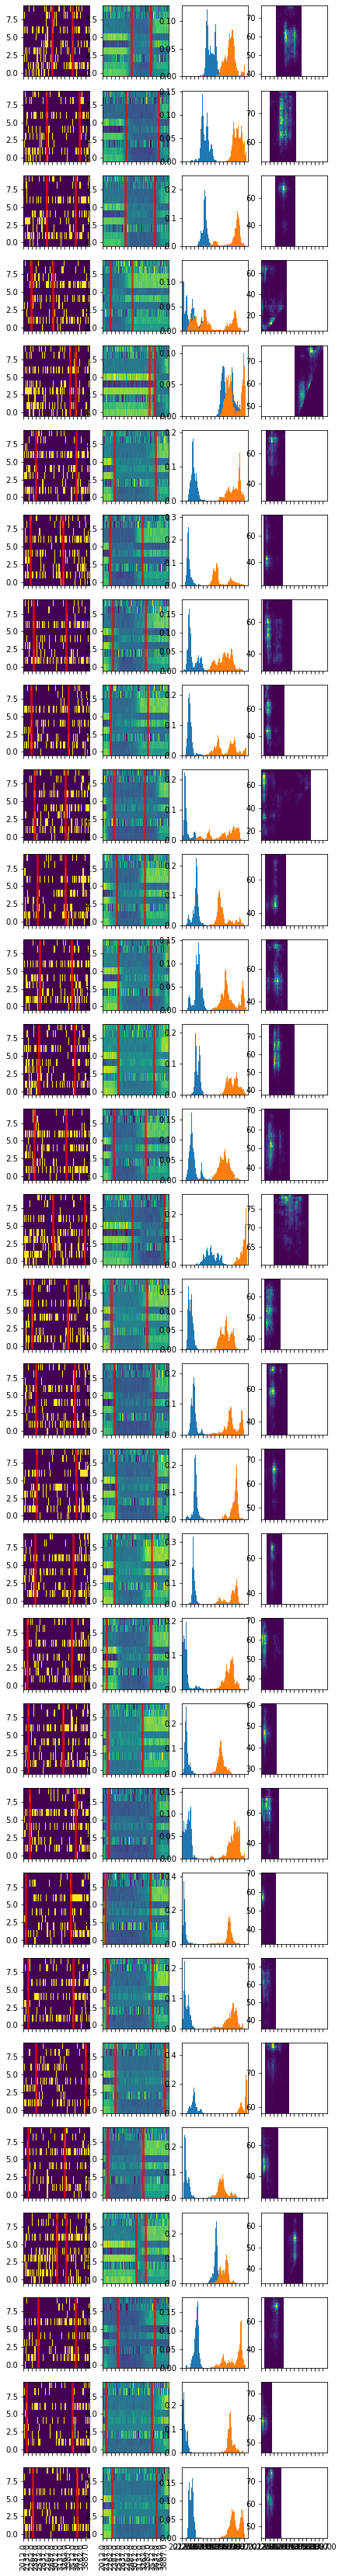

In [121]:
# Overlay raster with CDF of switchpoints
zscore_mean_ppc = np.stack([stats.zscore(mean_ppc[:,nrn],axis=None) for nrn in range(mean_ppc.shape[1])]).swapaxes(0,1)
fig, ax = plt.subplots(count_data.shape[0],4, figsize = (7,60),sharex=True)
for trial in range(count_data.shape[0]):
    ax[trial,0].imshow(count_data[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[trial,1].imshow(zscore_mean_ppc[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[trial,1].vlines(mean_tau[trial],-0.5,count_data.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)

    #fin_prob,this_x = np.histogram(tau_samples[:,trial].flatten(),100)
    #cum_prob = np.cumsum(fin_prob)
    #ax[trial,0].plot(this_x[1:],(cum_prob/np.max(cum_prob)*count_data.shape[1])-0.5, c = 'red');
    for state in range(tau_samples.shape[-1]):
        ax[trial,2].hist(tau_samples[:,trial,state], bins = 100, density = True)
    ax[trial,0].vlines(mean_tau[trial],-0.5,count_data.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
    ax[trial,3].hist2d(tau_samples[:,trial,0],tau_samples[:,trial,1],30)

for col in range(2):
    plt.sca(ax[-1,col])
    plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
    plt.xlim(0,len(binned_t_vec))
    
fig.savefig('predicted_transitions_per_trial')

In [114]:
# For visualization
# Take firing around each transition and stack it together
window_radius_time = 400 # ms
window_radius_bins = window_radius_time//bin_width
print(window_radius_bins)

# Convert tau to interegers
int_mean_tau = np.vectorize(np.int)(mean_tau)

# Take entire radius if available or whatever there is otherwise
# Iterate over changepoints and trials
# trials x neuron x switches x window_diameter
aligned_spikes = np.ones((*count_data.shape[:2],mean_tau.shape[-1],window_radius_bins*2))*-1
print(aligned_spikes.shape)
for trial in range(count_data.shape[0]):
    for switch in range(mean_tau.shape[-1]):
        # Check whether we can pick out a window
        lower_bound = (int_mean_tau[trial,switch] - window_radius_bins)
        fin_lower_bound = lower_bound * (lower_bound > 0)
        upper_bound = (int_mean_tau[trial,switch] + window_radius_bins)
        fin_upper_bound = upper_bound * (upper_bound < count_data.shape[-1]) + \
                                            count_data.shape[-1] * (upper_bound > count_data.shape[-1])
        
        # Done this way so all windows can be accomodated whether they are of the expected size or not
        lower_window = count_data[trial,:,fin_lower_bound:int_mean_tau[trial,switch]]
        upper_window = count_data[trial,:,int_mean_tau[trial,switch]:fin_upper_bound]
        aligned_spikes[trial,:,switch,(window_radius_bins - lower_window.shape[-1]):window_radius_bins] = lower_window
        aligned_spikes[trial,:,switch,window_radius_bins:(window_radius_bins + upper_window.shape[-1])] = upper_window


16
(30, 10, 2, 32)


In [115]:
# Stack trial vertically and switchpoints horizontally
# Remove trials with missing time
# Make lists of acceptable trials
# acceptable_trials = [[trial for trial in aligned_spikes[:,:,this_switch] if -1 not in trial]\
#                     for this_switch in range(aligned_spikes.shape[2])]
# fig, ax = plt.subplots(aligned_spikes.shape[2])
# for switch_num, this_switch in enumerate(acceptable_trials):
#     ax[switch_num].imshow(stats.zscore(np.mean(this_switch,axis=0),axis=-1), aspect='auto', origin='lower');
    
# fig, ax = plt.subplots(aligned_spikes.shape[0], aligned_spikes.shape[2], figsize = (3,30))
# for switch_num, this_switch in enumerate(acceptable_trials):
#    for trial_num, this_trial in enumerate(this_switch):
#        ax[trial_num, switch_num].imshow(this_trial, aspect='auto', origin='lower');

(30, 10, 6950)
(30, 10, 2, 800)
(30, 10, 2, 800)


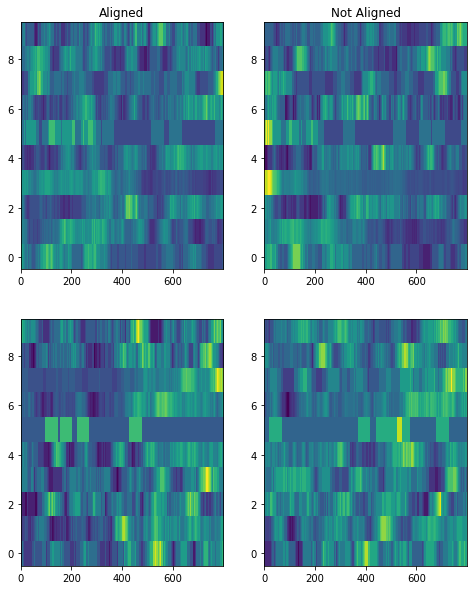

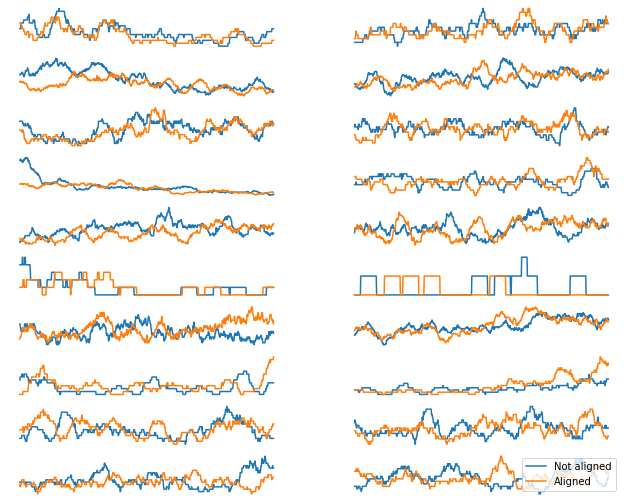

In [116]:
# Plot average firing of each neuron before and after the alignment
# Calculate firing rates for entire dataset
window_size = 50
step_size = 1
start_inds = np.arange(taste_dat.shape[-1] - window_size,step = step_size)
end_inds = start_inds + window_size
firing_array = np.stack([taste_dat[...,start:end] for start,end in zip(start_inds,end_inds)],axis=-2)
firing_array = np.mean(firing_array, axis=-1)
print(firing_array.shape)
#plt.imshow(firing_array[0],aspect = 'auto', origin='lower');

# Take start inds as time_vec for firing
firing_t_vec = start_inds
# Find inds for switchpoints in firing rate
absolute_switch_time = binned_t_vec[int_mean_tau]
time_diff_array = firing_t_vec[:,np.newaxis,np.newaxis] - absolute_switch_time[np.newaxis,:,:]
firing_switch_ind = np.argmin(time_diff_array**2,axis=0)
#print(firing_switch_ind)

window_radius_time = 400 # ms
window_radius_bins = window_radius_time//step_size

# Take entire radius if available or whatever there is otherwise
# Iterate over changepoints and trials
# trials x neuron x switches x window_diameter
aligned_firing = np.ones((*firing_array.shape[:2],mean_tau.shape[-1],window_radius_bins*2))*-1
print(aligned_firing.shape)
for trial in range(aligned_firing.shape[0]):
    for switch in range(mean_tau.shape[-1]):
        # Check whether we can pick out a window
        lower_bound = (firing_switch_ind[trial,switch] - window_radius_bins)
        fin_lower_bound = lower_bound * (lower_bound > 0)
        upper_bound = (firing_switch_ind[trial,switch] + window_radius_bins)
        fin_upper_bound = upper_bound * (upper_bound < firing_array.shape[-1]) + \
                                            firing_array.shape[-1] * (upper_bound > firing_array.shape[-1])
        
        # Done this way so all windows can be accomodated whether they are of the expected size or not
        lower_window = firing_array[trial,:,fin_lower_bound:firing_switch_ind[trial,switch]]
        upper_window = firing_array[trial,:,firing_switch_ind[trial,switch]:fin_upper_bound]
        aligned_firing[trial,:,switch,(window_radius_bins - lower_window.shape[-1]):window_radius_bins] = lower_window
        aligned_firing[trial,:,switch,window_radius_bins:(window_radius_bins + upper_window.shape[-1])] = upper_window

# Create unaligned firing from mean_value of tau
mean_mean_tau = np.mean(mean_tau,axis=0)
int_mean_mean_tau = np.vectorize(np.int)(mean_mean_tau)
unaligned_switch_absolute_time = binned_t_vec[int_mean_mean_tau]
unaligned_time_diff_array = firing_t_vec[:,np.newaxis] - unaligned_switch_absolute_time[np.newaxis,:]
unaligned_firing_switch_ind = np.argmin(unaligned_time_diff_array**2,axis=0)

unaligned_firing = np.ones((*firing_array.shape[:2],mean_tau.shape[-1],window_radius_bins*2))*-1
print(unaligned_firing.shape)
for trial in range(unaligned_firing.shape[0]):
    for switch in range(mean_tau.shape[-1]):
        # Check whether we can pick out a window
        lower_bound = (unaligned_firing_switch_ind[switch] - window_radius_bins)
        fin_lower_bound = lower_bound * (lower_bound > 0)
        upper_bound = (unaligned_firing_switch_ind[switch] + window_radius_bins)
        fin_upper_bound = upper_bound * (upper_bound < firing_array.shape[-1]) + \
                                            firing_array.shape[-1] * (upper_bound > firing_array.shape[-1])
        
        # Done this way so all windows can be accomodated whether they are of the expected size or not
        lower_window = firing_array[trial,:,fin_lower_bound:unaligned_firing_switch_ind[switch]]
        upper_window = firing_array[trial,:,unaligned_firing_switch_ind[switch]:fin_upper_bound]
        unaligned_firing[trial,:,switch,(window_radius_bins - lower_window.shape[-1]):window_radius_bins] = lower_window
        unaligned_firing[trial,:,switch,window_radius_bins:(window_radius_bins + upper_window.shape[-1])] = upper_window

# Plot mean firing transition for every state
fig, ax = plt.subplots(aligned_firing.shape[2], 2, figsize = (8,10))
for ax_num in range(ax.shape[0]):
    ax[ax_num,0].imshow(stats.zscore(np.mean(aligned_firing[:,:,ax_num],axis=0),axis=-1),aspect='auto',origin='lower');
    ax[ax_num,1].imshow(stats.zscore(np.mean(unaligned_firing[:,:,ax_num],axis=0),axis=-1),aspect='auto',origin='lower');
    ax[0,0].set_title('Aligned')
    ax[0,1].set_title('Not Aligned')
fig.savefig('Comparison_average_transition')
    
fig, ax = plt.subplots(aligned_firing.shape[1], aligned_firing.shape[2])
x = np.arange(aligned_firing.shape[-1])
for nrn in range(ax.shape[0]):
    for switch in range(ax.shape[1]):
        mean_aligned = np.mean(aligned_firing[:,nrn,switch],axis=0)
        std_aligned = np.std(aligned_firing[:,nrn,switch],axis=0)
        mean_unaligned = np.mean(unaligned_firing[:,nrn,switch],axis=0)
        std_unaligned = np.std(unaligned_firing[:,nrn,switch],axis=0)
#         ax[nrn,switch].fill_between(
#                             x = x,
#                             y1 = mean_unaligned + std_unaligned,
#                             y2 = mean_unaligned - std_unaligned, alpha = 0.5)
        ax[nrn,switch].plot(mean_unaligned, label = 'Not aligned')
#         ax[nrn,switch].fill_between(
#                             x = x,
#                             y1 = mean_aligned + std_aligned,
#                             y2 = mean_aligned - std_aligned, alpha = 0.5)
        ax[nrn,switch].plot(mean_aligned, label = 'Aligned')
        ax[nrn,switch].axis('off')
plt.legend();
fig.savefig('comparison_average_firing')